This Jupyter Notebook trains/tests/compares the following models on the EMNIST dataset:

1. EfficientNetV2-S
2. EfficientNet-B4

As both are roughly similar in size, it would be interesting to compare their performance.

If something doesn't make sense, the below link is a useful guide:
https://pytorch.org/tutorials/beginner/introyt/trainingyt.html


Load required libraries

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from collections import Counter
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import tqdm
import matplotlib.pyplot as plt
import numpy as np

Load the EMNIST dataset and apply transformations to the images as these efficientnet models require images with dimensions [3,224,224].

In [ ]:
# Transform the images...so it's absolutely necessary to change the input size but probably best to also normalise the images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_train = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
dataset_test = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Set up the training and evaluation loop, save the model that performs best on the eval set.


In [ ]:
def train_test_loop(model, model_name, train_loader, test_loader,total_epochs=5):
  torch.manual_seed(0)
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print(f'Using device: {device}')

  model.train()
  lr = 0.005
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  #keep track of metrics
  total_train_loss = []
  total_train_acc = []
  total_val_loss = []
  total_val_acc = []
  best_acc = 0

  for epoch in range(total_epochs):
      #Put model in training mode and load it to GPU.
      model.train()
      model = model.to(device)

      #Training loop
      train_loss = []
      correct = 0
      total = 0
      for i, data in  tqdm.tqdm(enumerate(train_loader, 0), total = len(train_loader), desc = f'Epoch {epoch+1} - training phase'):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = (labels - 1).to(device)

          optimizer.zero_grad()
          outputs = model(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += [loss.cpu().item()]
          predicted = torch.argmax(outputs, axis = 1)
          correct += torch.sum(predicted == labels).cpu().item()
          total += len(labels)

      mean_train_loss = np.mean(train_loss)
      train_accuracy = correct/total

      total_train_loss += [mean_train_loss]
      total_train_acc += [train_accuracy]

      #Perform test loop
      model.eval()
      val_loss = []
      correct = 0
      total = 0

      for data in test_loader:
          inputs, labels = data

          inputs = inputs.to(device)
          labels = (labels - 1).to(device)

          #pass through model classifier
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          val_loss += [loss.cpu().item()]
          predicted = torch.argmax(outputs, axis = 1)
          correct += torch.sum(predicted == labels).cpu().item()
          total += len(labels)

      mean_val_loss = np.mean(val_loss)
      val_accuracy = correct/total
      total_val_loss += [mean_val_loss]
      total_val_acc += [val_accuracy]

      if val_accuracy > best_acc:
          best_acc = val_accuracy
          torch.save(model.state_dict(), f'./Models/{model_name}.pth')
          print(f'Saving model at epoch {epoch} with accuracy {val_accuracy}')


  plt.plot(total_train_loss, label = 'Train')
  plt.plot(total_val_loss, label = 'Val')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(total_train_acc, label = 'Train')
  plt.plot(total_val_acc, label = 'Val')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.show()

Instanstiate each model and train:

In [ ]:
num_classes = 26
efficientnetv2_s = models.efficientnet_v2_s(num_classes=num_classes, weights=None)
efficientnet_b4 = models.efficientnet_b4(num_classes=num_classes, weights=None)

Using device: cuda:0


Epoch 1 - training phase: 100%|██████████| 1950/1950 [06:37<00:00,  4.90it/s]


Saving model at epoch 0 with accuracy 0.9286538461538462


Epoch 2 - training phase: 100%|██████████| 1950/1950 [06:36<00:00,  4.92it/s]


Saving model at epoch 1 with accuracy 0.9358653846153846


Epoch 4 - training phase: 100%|██████████| 1950/1950 [06:39<00:00,  4.88it/s]


Saving model at epoch 3 with accuracy 0.9389903846153846


Epoch 5 - training phase: 100%|██████████| 1950/1950 [06:35<00:00,  4.93it/s]


Saving model at epoch 4 with accuracy 0.9457692307692308


Epoch 7 - training phase: 100%|██████████| 1950/1950 [06:38<00:00,  4.90it/s]


Saving model at epoch 6 with accuracy 0.9483173076923077


Epoch 8 - training phase: 100%|██████████| 1950/1950 [06:46<00:00,  4.80it/s]


Saving model at epoch 7 with accuracy 0.9508653846153846


Epoch 10 - training phase: 100%|██████████| 1950/1950 [06:37<00:00,  4.90it/s]


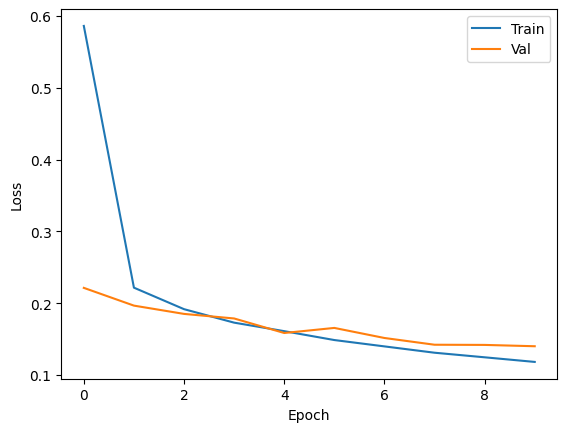

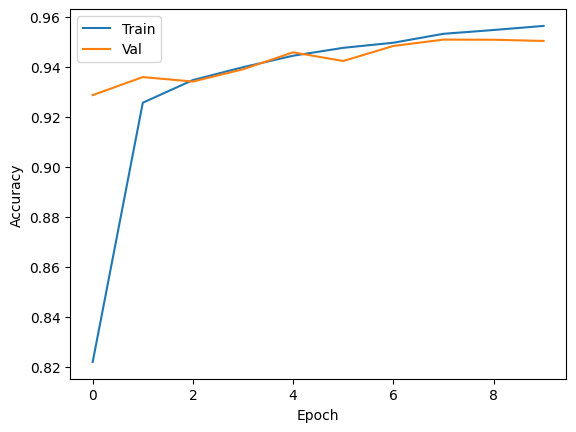

In [ ]:
# Run training and evaluation
model_name = 'efficientnetv2_s'
train_test_loop(model=efficientnetv2_s, model_name=model_name, train_loader=train_loader, test_loader=test_loader,total_epochs=10)

From the loss and accuracy charts, EfficientNetV2-S model can be trained further with possibly a lower learning rate.

Training for 10 epochs produced a 95% accuracy. The training time for 10 epochs is about 66 minutes.

Using device: cuda:0


Epoch 1 - training phase: 100%|██████████| 1950/1950 [07:58<00:00,  4.07it/s]


Saving model at epoch 0 with accuracy 0.9316826923076923


Epoch 2 - training phase: 100%|██████████| 1950/1950 [07:58<00:00,  4.08it/s]


Saving model at epoch 1 with accuracy 0.937548076923077


Epoch 4 - training phase: 100%|██████████| 1950/1950 [07:58<00:00,  4.08it/s]


Saving model at epoch 3 with accuracy 0.9384134615384615


Epoch 5 - training phase: 100%|██████████| 1950/1950 [07:59<00:00,  4.07it/s]


Saving model at epoch 4 with accuracy 0.9470673076923077


Epoch 7 - training phase: 100%|██████████| 1950/1950 [07:58<00:00,  4.08it/s]


Saving model at epoch 6 with accuracy 0.9500961538461539


Epoch 8 - training phase: 100%|██████████| 1950/1950 [07:58<00:00,  4.07it/s]


Saving model at epoch 7 with accuracy 0.9521153846153846


Epoch 10 - training phase: 100%|██████████| 1950/1950 [07:59<00:00,  4.07it/s]


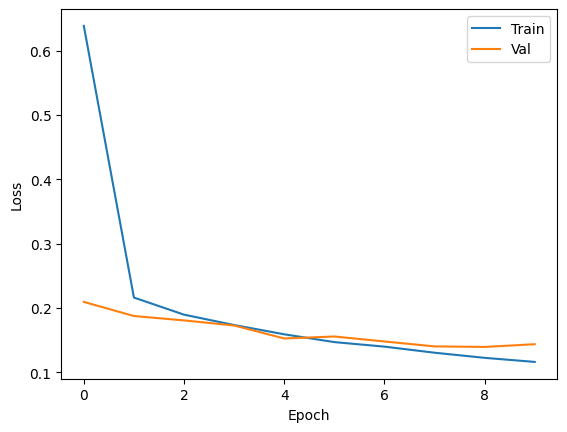

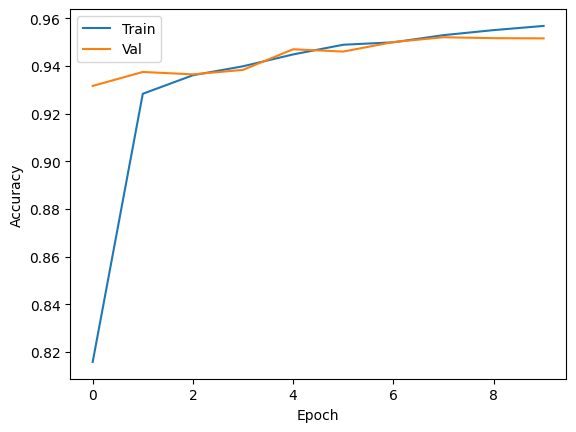

In [ ]:
# Run training and evaluation
model_name = 'efficientnet_b4'
train_test_loop(model=efficientnet_b4, model_name=model_name, train_loader=train_loader, test_loader=test_loader,total_epochs=10)

Training time took approximately 80 minutes with a 95% accuracy.